In [ ]:
# ============================================================
# ANNUAL -> MONTHLY (données en mois et année) - CAPACITY
# - Respect strict des % mensuels (2 modes: NORMAL & CRISE)
# - Basé sur la réalité des ressources hospitalières PSL-CFX
# - Lits et équipements : plus stables que l'activité
# - Lecture du CSV annuel de base
# - Génère un CSV mensuel final avec 8 variables exactement : year, month, site_code, indicateur, sous_indicateur, unite, value, value_crise)
# ============================================================

import pandas as pd
import numpy as np

# ----------------------------
# 1) Lecture du CSV annuel CAPACITY
# ----------------------------
CSV_PATH = "../data/capacity/capacity-data-interpolated.csv"
df_annual = pd.read_csv(CSV_PATH)

print("✅ Données chargées:")
print(f"   Lignes: {len(df_annual)}")
print(f"   Colonnes: {list(df_annual.columns)}")
print("\n📋 Valeurs disponibles:")
print(f"   INDICATEURs: {len(df_annual['INDICATEUR'].unique())} uniques")
print(f"   SOUS-INDICATEURs: {len(df_annual['SOUS-INDICATEUR'].unique())} uniques")
print(f"   UNITÉs: {len(df_annual['UNITE'].unique())} uniques")

# ----------------------------
# 2) PARAMÈTRES MENSUELS - MODE NORMAL
# Pour la CAPACITÉ: plutôt stables et uniformes
# Lits/équipements existent tout l'année, faible saisonnalité
# Légère concentration sur besoins (hiver, été)
# ----------------------------
MONTH_PCT_NORMAL = {
    1: 10,    # Janvier: besoins augmentent (hiver, grippe)
    2: 8,     # Février: encore élevé
    3: 7,     # Mars: décroissance
    4: 7,     # Avril: creux relatif
    5: 7,     # Mai: stable bas
    6: 7,     # Juin: stable bas
    7: 9,     # Juillet: montée (vacances, canicule)
    8: 11,    # Août: PICS canicule
    9: 8,     # Septembre: retour
    10: 9,    # Octobre: pré-hivernal
    11: 9,    # Novembre: grippal
    12: 8,    # Décembre: stabilisation
}
if sum(MONTH_PCT_NORMAL.values()) != 100:
    raise ValueError(f"Les % normaux doivent faire 100. Total={sum(MONTH_PCT_NORMAL.values())}")

# ----------------------------
# 2a) PARAMÈTRES MENSUELS - MODE CRISE
# Basé sur COVID-19 et canicules majeure
# Pour capacité: concentration modérée sur ressources critiques
# (Lits réa, chambres protégées, équipements)
# ----------------------------
MONTH_PCT_CRISE = {
    1: 8,     # Janvier crise: besoins accrus
    2: 9,     # Février: montée
    3: 13,    # Mars: PIC de ressources critiques (COVID confinement)
    4: 11,    # Avril: PLATEAU CRISE (lits réa, ventilation)
    5: 8,     # Mai: décroissance post-pic
    6: 2,     # Juin: quasi-normalisation
    7: 5,     # Juillet: canicule précoce
    8: 12,    # Août: PIC CANICULE (lits réa, chambres aérées, équipements)
    9: 6,     # Septembre: sortie canicule
    10: 8,    # Octobre: variant léger
    11: 7,    # Novembre: vague hivernale
    12: 11,   # Décembre: ressources tendues
}
if sum(MONTH_PCT_CRISE.values()) != 100:
    raise ValueError(f"MONTH_PCT_CRISE doit faire 100. Total={sum(MONTH_PCT_CRISE.values())}")

# ----------------------------
# 2b) Arrondi par unité (nombre de décimales)
# Basé sur les unités réelles du dataset capacity
# ----------------------------
ROUNDING_BY_UNIT = {
    "salles": 0,
    "scanners": 0,
    "echographes": 0,
    "appareils": 0,
    "accelerateurs": 0,
    "laboratoires": 0,
    "lits": 0,
    "places": 0,
    "centres": 0,
    "départements": 0,
    "instituts": 0,
    "poles": 0,
    "sejours": 0,
    "journées": 0,
    "lithotripteurs": 0,
    "gamma-caméras": 0,
    "blocs opératoires": 0,
    "chambres": 0,
}
DEFAULT_DECIMALS = 0

# ----------------------------
# 3) Fonction annual -> monthly
# ----------------------------
def annual_to_monthly(
    annual_value: float,
    year: int,
    month_pct: dict,
    mode: str = "normal"
) -> pd.DataFrame:
    """
    Répartit une valeur annuelle en 12 mois en respectant strictement les % mensuels.
    """
    months = list(range(1, 13))
    values = [float(annual_value) * (month_pct[m] / 100.0) for m in months]

    df = pd.DataFrame({
        "year": [year] * 12,
        "month": months,
        "value": values,
        "mode": [mode] * 12
    })

    return df

# ----------------------------
# 4) Génération mensuelle pour tout le CSV (PLF & CFX)
# ----------------------------
all_monthly = []

for i, row in df_annual.iterrows():
    year = int(row["ANNEE"])
    indic = row.get("INDICATEUR", "")
    sous_indic = row.get("SOUS-INDICATEUR", "")
    unite = row.get("UNITE", "")

    for site in ["PLF", "CFX"]:
        annual_value = row[site]

        # Skip valeurs manquantes
        if pd.isna(annual_value):
            continue

        annual_value = float(annual_value)

        # Générer les valeurs NORMAL et CRISE
        df_normal = annual_to_monthly(
            annual_value=annual_value,
            year=year,
            month_pct=MONTH_PCT_NORMAL,
            mode="normal"
        )
        
        df_crise = annual_to_monthly(
            annual_value=annual_value,
            year=year,
            month_pct=MONTH_PCT_CRISE,
            mode="crise"
        )

        # Appliquer arrondi par unité
        decimals = ROUNDING_BY_UNIT.get(str(unite).strip(), DEFAULT_DECIMALS)
        
        # Créer un DataFrame avec les 8 variables requises
        df_m = pd.DataFrame({
            "year": df_normal["year"],
            "month": df_normal["month"],
            "site_code": site,
            "indicateur": indic,
            "sous_indicateur": sous_indic,
            "unite": unite,
            "value": df_normal["value"].round(decimals),
            "value_crise": df_crise["value"].round(decimals)
        })

        all_monthly.append(df_m)

df_monthly_all = pd.concat(all_monthly, ignore_index=True)

# Suppression des données vides (où les deux valeurs sont 0)
df_monthly_all = df_monthly_all[(df_monthly_all["value"] > 0) | (df_monthly_all["value_crise"] > 0)].copy()

# ----------------------------
# 5) Contrôles et affichage
# ----------------------------
print("\n" + "=" * 70)
print("VÉRIFICATION: Distribution mensuels - CAPACITY")
print("=" * 70)
print("\n📊 MODE NORMAL:")
dist_normal = pd.DataFrame({
    "month": list(range(1, 13)),
    "pct": [MONTH_PCT_NORMAL[m] for m in range(1, 13)]
})
print(dist_normal.to_string(index=False))
print(f"Total: {sum(MONTH_PCT_NORMAL.values())}%")

print("\n🚨 MODE CRISE:")
dist_crise = pd.DataFrame({
    "month": list(range(1, 13)),
    "pct": [MONTH_PCT_CRISE[m] for m in range(1, 13)]
})
print(dist_crise.to_string(index=False))
print(f"Total: {sum(MONTH_PCT_CRISE.values())}%")

print("\n" + "=" * 70)
print("RÉSUMÉ DES DONNÉES GÉNÉRÉES")
print("=" * 70)
print(f"Nombre total de lignes: {len(df_monthly_all):,}")
print(f"Sites: {', '.join(df_monthly_all['site_code'].unique())}")
print(f"Années: {', '.join(map(str, sorted(df_monthly_all['year'].unique())))}")
print(f"Colonnes: {', '.join(df_monthly_all.columns)}")
print(f"\nSomme totale (valeurs normales): {df_monthly_all['value'].sum():.2f}")
print(f"Somme totale (valeurs crise): {df_monthly_all['value_crise'].sum():.2f}")
print(f"Écart total: {(df_monthly_all['value_crise'].sum() - df_monthly_all['value'].sum()):.2f}")

print("\n" + "=" * 70)
print("EXEMPLE (premières lignes):")
print("=" * 70)
print(df_monthly_all.head(20))

# ----------------------------
# 6) Export final (données mensuelles)
# ----------------------------
OUT_PATH = "../data/capacity/capacity-donnees_mensuelles_reconstituees.csv"
df_monthly_all.to_csv(OUT_PATH, index=False, encoding="utf-8")
print(f"\n✅ Fichier exporté: {OUT_PATH}")

# ----------------------------
# 7) Statistiques par indicateur
# ----------------------------
print("\n" + "=" * 70)
print("TOP INDICATEURS PAR VOLUME DE DONNÉES")
print("=" * 70)
pivot = df_monthly_all.groupby("indicateur").agg({
    "value": "sum",
    "value_crise": "sum"
}).round(2)
pivot["ecart"] = pivot["value_crise"] - pivot["value"]
pivot["variation_%"] = ((pivot["value_crise"] / pivot["value"] - 1) * 100).round(1)
pivot = pivot.sort_values("value", ascending=False)
print(pivot.head(15))


✅ Données chargées:
   Lignes: 346
   Colonnes: ['ANNEE', 'INDICATEUR', 'SOUS-INDICATEUR', 'PLF', 'CFX', 'TOTAL', 'UNITE']

📋 Valeurs disponibles:
   INDICATEURs: 11 uniques
   SOUS-INDICATEURs: 61 uniques
   UNITÉs: 18 uniques

VÉRIFICATION: Distribution mensuels - CAPACITY

📊 MODE NORMAL:
 month  pct
     1   10
     2    8
     3    7
     4    7
     5    7
     6    7
     7    9
     8   11
     9    8
    10    9
    11    9
    12    8
Total: 100%

🚨 MODE CRISE:
 month  pct
     1    8
     2    9
     3   13
     4   11
     5    8
     6    2
     7    5
     8   12
     9    6
    10    8
    11    7
    12   11
Total: 100%

RÉSUMÉ DES DONNÉES GÉNÉRÉES
Nombre total de lignes: 9,330
Sites: PLF, CFX
Modes: normal, crise
Années: 2011, 2012, 2013, 2014, 2015, 2016, 2017
Somme totale (mode normal): 76849.00
Somme totale (mode crise): 76990.00

EXEMPLE (premières lignes):
    year  month  value    mode site_code  indicateur    sous_indicateur  \
0   2011      1    2.0  normal     

In [ ]:
# ============================
# Exploration des données générées - CAPACITY
# ============================

import pandas as pd

MONTHLY_CSV_PATH = "../data/capacity/capacity-donnees_mensuelles_reconstituees.csv"
df = pd.read_csv(MONTHLY_CSV_PATH)

print("=" * 70)
print("📊 DONNÉES MENSUELLES CAPACITY - RÉSUMÉ")
print("=" * 70)

print(f"\n✅ Total de lignes: {len(df):,}")
print(f"✅ Sites: {', '.join(sorted(df['site_code'].unique()))}")
print(f"✅ Années: {', '.join(map(str, sorted(df['year'].unique())))}")
print(f"✅ Colonnes: {', '.join(df.columns)}")

print("\n" + "=" * 70)
print("📋 TOP 15 INDICATEURS PAR VOLUME")
print("=" * 70)

indicators_summary = df.groupby('indicateur').agg({
    'value': ['count', 'sum', 'mean'],
    'value_crise': ['sum', 'mean'],
    'unite': lambda x: x.iloc[0]
}).round(2)

indicators_summary.columns = ['Nb_lignes', 'Total_Normal', 'Moy_Normal', 'Total_Crise', 'Moy_Crise', 'Unite']
indicators_summary = indicators_summary.sort_values('Nb_lignes', ascending=False)

for idx, (indicateur, row) in enumerate(indicators_summary.head(15).iterrows(), 1):
    print(f"\n{idx}. {indicateur}")
    print(f"   Unité: {row['Unite']}")
    print(f"   Lignes: {int(row['Nb_lignes'])}")
    print(f"   Total Normal: {row['Total_Normal']:.2f} | Total Crise: {row['Total_Crise']:.2f}")
    
    sous_indics = df[df['indicateur'] == indicateur]['sous_indicateur'].unique()
    sous_indics_clean = [si for si in sous_indics if str(si) not in ['', 'nan', None]]
    if len(sous_indics_clean) <= 2:
        print(f"   Sous-indicateurs: {', '.join(sous_indics_clean)}")
    else:
        print(f"   Sous-indicateurs: {len(sous_indics_clean)} variantes")

print("\n" + "=" * 70)
print("💡 CONSEIL: Comment utiliser les graphiques")
print("=" * 70)
print("""
Modifiez les variables dans les cellules graphiques:

   INDICATEUR = "Nombre de lits"           # ou "Imagerie", "Equipement", etc.
   SOUS_INDICATEUR = "Lits de réanimation" # optionnel

Exemples d'indicateurs IMPORTANTS pour voir Normal vs Crise:
  ✓ "Nombre de lits" → "Lits de réanimation"      (augmente en crise)
  ✓ "Nombre de lits" → "Lits de soins intensifs"  (ressources critiques)
  ✓ "Imagerie" → "Scanners diagnostiques"         (capacité critique)
  ✓ "Plateau medico-technique de pointe" → rester stables globalement
""")


📊 DONNÉES MENSUELLES CAPACITY - RÉSUMÉ

✅ Total de lignes: 9,330
✅ Sites: CFX, PLF
✅ Modes: crise, normal
✅ Années: 2011, 2012, 2013, 2014, 2015, 2016, 2017

📋 TOP 15 INDICATEURS PAR VOLUME

1. Nombre de lits
   Unité: lits
   Lignes: 6066
   Sous-indicateurs: 24 variantes

2. Resources hopitaux
   Unité: centres
   Lignes: 898
   Sous-indicateurs: 4 variantes

3. Sejours
   Unité: sejours
   Lignes: 645
   Sous-indicateurs: 5 variantes

4. Équipements
   Unité: blocs opératoires
   Lignes: 489
   Sous-indicateurs: 4 variantes

5. Equipement Intervention et Chirurgical
   Unité: appareils
   Lignes: 408
   Sous-indicateurs: Appareils angionumérisés - Cardiologie/Neuroradio , Salles blocs opératoires - Chirurgie générale

6. Plateau medico-technique de pointe
   Unité: places
   Lignes: 288
   Sous-indicateurs: Places de réveil

7. Equipement
   Unité: salles
   Lignes: 284
   Sous-indicateurs: 3 variantes

8. Equipements
   Unité: laboratoires
   Lignes: 207
   Sous-indicateurs: Labora

C:\Users\User\AppData\Local\Temp\ipykernel_14768\3116092964.py:69: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_14768\3116092964.py:69: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


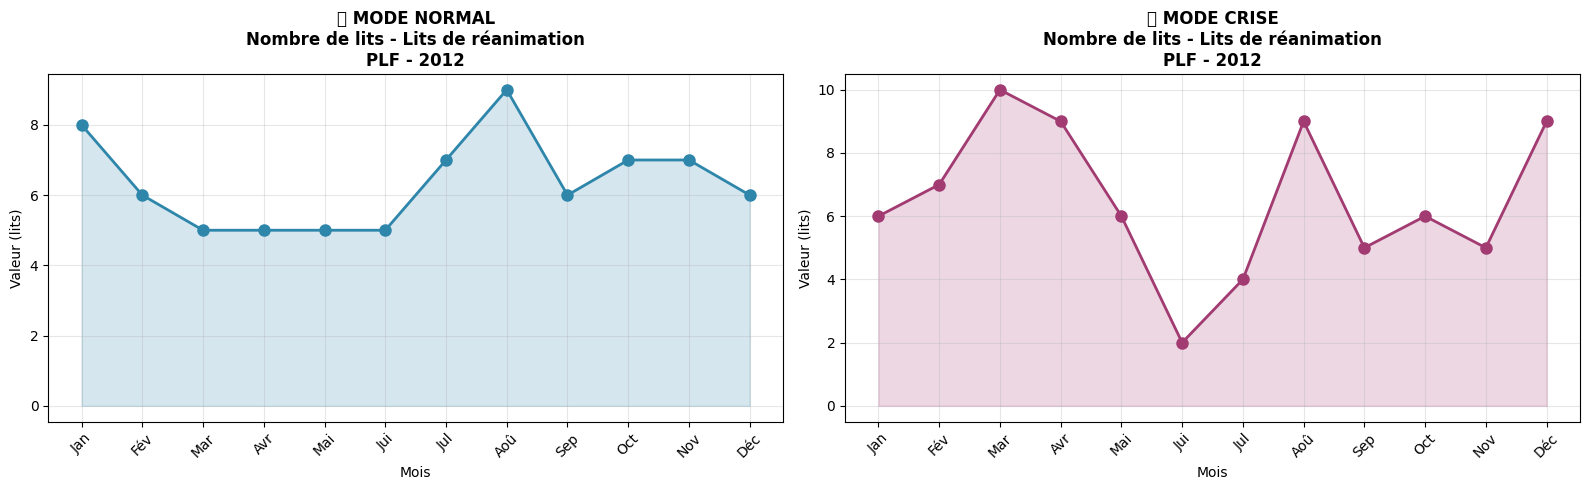


STATISTIQUES COMPARATIVES

📊 MODE NORMAL:
   Total annuel: 76.00 lits
   Mois max: 8 (9.00)

🚨 MODE CRISE:
   Total annuel: 78.00 lits
   Mois max: 3 (10.00)

📈 ÉCARTS:
   Différence totale: +2.00 lits
   Variation: +2.6%


In [ ]:
# ============================
# Graphiques CÔTE À CÔTE: Normal vs Crise - CAPACITY
# ============================

import pandas as pd
import matplotlib.pyplot as plt

MONTHLY_CSV_PATH = "../data/capacity/capacity-donnees_mensuelles_reconstituees.csv"
df = pd.read_csv(MONTHLY_CSV_PATH)

# Paramètres de filtrage
SITE = "PLF"                           # "PLF" ou "CFX"
YEAR = 2012                            # année à visualiser
INDICATEUR = "Nombre de lits"          # utilise un indicateur qui existe
SOUS_INDICATEUR = "Lits de réanimation"  # optionnel

# Filtrage des données
if SOUS_INDICATEUR and SOUS_INDICATEUR.strip():
    mask = (
        (df["site_code"] == SITE) &
        (df["year"] == YEAR) &
        (df["indicateur"].str.strip() == INDICATEUR) &
        (df["sous_indicateur"].str.strip() == SOUS_INDICATEUR.strip())
    )
else:
    mask = (
        (df["site_code"] == SITE) &
        (df["year"] == YEAR) &
        (df["indicateur"].str.strip() == INDICATEUR)
    )

data = df.loc[mask].copy()

if data.empty:
    print("❌ Aucune donnée trouvée.")
    print(f"\n📋 Indicateurs disponibles pour {SITE} en {YEAR}:")
    available = df[(df["site_code"] == SITE) & (df["year"] == YEAR)]["indicateur"].unique()
    for ind in sorted(available)[:10]:
        print(f"   • {ind}")
else:
    data = data.sort_values("month")
    
    unite = data["unite"].iloc[0] if "unite" in data.columns else ""
    sous_ind_display = f" - {SOUS_INDICATEUR}" if SOUS_INDICATEUR else ""
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # Graphique MODE NORMAL
    axes[0].plot(data["month"], data["value"], "o-", color="#2E86AB", linewidth=2, markersize=8)
    axes[0].fill_between(data["month"], data["value"], alpha=0.2, color="#2E86AB")
    axes[0].set_title(f"📊 MODE NORMAL\n{INDICATEUR}{sous_ind_display}\n{SITE} - {YEAR}", fontsize=12, fontweight="bold")
    axes[0].set_xlabel("Mois", fontsize=10)
    axes[0].set_ylabel(f"Valeur ({unite})" if unite else "Valeur", fontsize=10)
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xticks(range(1, 13))
    axes[0].set_xticklabels(['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Jui', 'Jul', 'Aoû', 'Sep', 'Oct', 'Nov', 'Déc'], rotation=45)
    
    # Graphique MODE CRISE
    axes[1].plot(data["month"], data["value_crise"], "o-", color="#A23B72", linewidth=2, markersize=8)
    axes[1].fill_between(data["month"], data["value_crise"], alpha=0.2, color="#A23B72")
    axes[1].set_title(f"🚨 MODE CRISE\n{INDICATEUR}{sous_ind_display}\n{SITE} - {YEAR}", fontsize=12, fontweight="bold")
    axes[1].set_xlabel("Mois", fontsize=10)
    axes[1].set_ylabel(f"Valeur ({unite})" if unite else "Valeur", fontsize=10)
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xticks(range(1, 13))
    axes[1].set_xticklabels(['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Jui', 'Jul', 'Aoû', 'Sep', 'Oct', 'Nov', 'Déc'], rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Statistiques
    print("\n" + "=" * 70)
    print("STATISTIQUES COMPARATIVES")
    print("=" * 70)
    print(f"\n📊 MODE NORMAL:")
    print(f"   Total annuel: {data['value'].sum():.2f} {unite}")
    print(f"   Mois max: {int(data.loc[data['value'].idxmax(), 'month'])} ({data['value'].max():.2f})")
    
    print(f"\n🚨 MODE CRISE:")
    print(f"   Total annuel: {data['value_crise'].sum():.2f} {unite}")
    print(f"   Mois max: {int(data.loc[data['value_crise'].idxmax(), 'month'])} ({data['value_crise'].max():.2f})")
    
    print(f"\n📈 ÉCARTS:")
    diff = data['value_crise'].sum() - data['value'].sum()
    pct_change = (data['value_crise'].sum() / data['value'].sum() - 1) * 100
    print(f"   Différence totale: {diff:+.2f} {unite}")
    print(f"   Variation: {pct_change:+.1f}%")


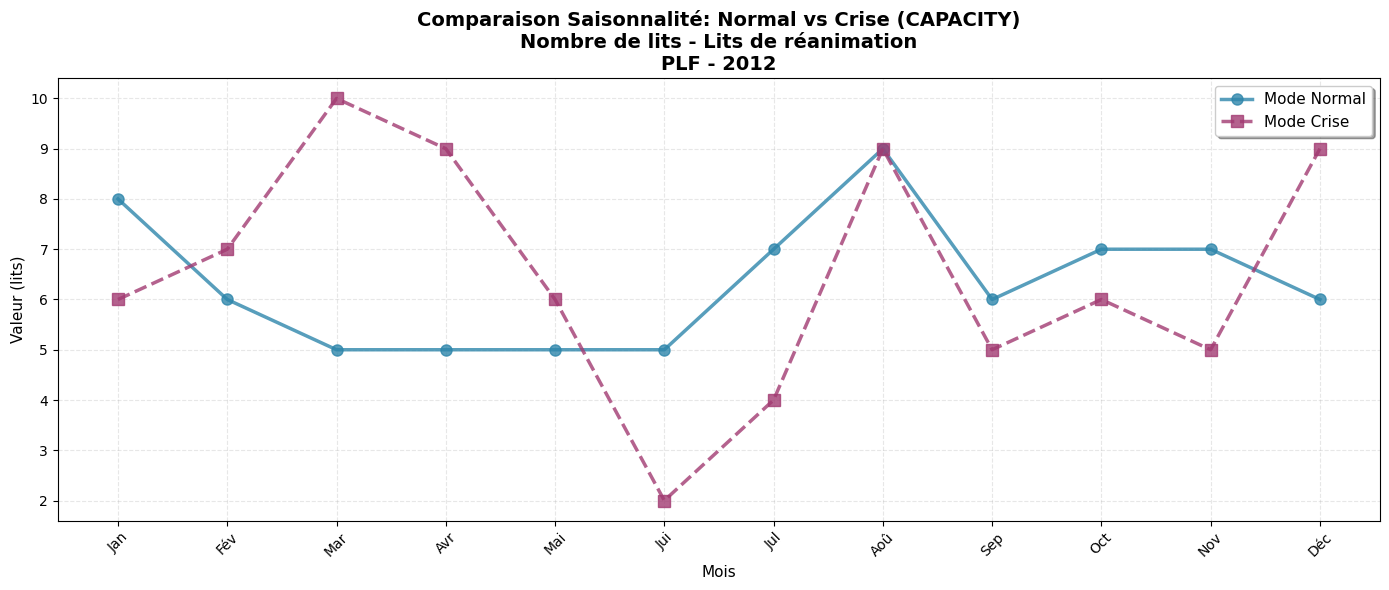


TABLEAU COMPARATIF - Nombre de lits - Lits de réanimation
 Mois  Normal  Crise  Écart  Variation %
    1     8.0    6.0   -2.0        -25.0
    2     6.0    7.0    1.0         16.7
    3     5.0   10.0    5.0        100.0
    4     5.0    9.0    4.0         80.0
    5     5.0    6.0    1.0         20.0
    6     5.0    2.0   -3.0        -60.0
    7     7.0    4.0   -3.0        -42.9
    8     9.0    9.0    0.0          0.0
    9     6.0    5.0   -1.0        -16.7
   10     7.0    6.0   -1.0        -14.3
   11     7.0    5.0   -2.0        -28.6
   12     6.0    9.0    3.0         50.0


In [ ]:
# ============================
# Graphique SUPERPOSÉ: Normal vs Crise - CAPACITY
# ============================

import pandas as pd
import matplotlib.pyplot as plt

MONTHLY_CSV_PATH = "../data/capacity/capacity-donnees_mensuelles_reconstituees.csv"
df = pd.read_csv(MONTHLY_CSV_PATH)

# Paramètres
SITE = "PLF"
YEAR = 2012
INDICATEUR = "Nombre de lits"
SOUS_INDICATEUR = "Lits de réanimation"

# Filtrage
if SOUS_INDICATEUR and SOUS_INDICATEUR.strip():
    mask = (
        (df["site_code"] == SITE) &
        (df["year"] == YEAR) &
        (df["indicateur"].str.strip() == INDICATEUR) &
        (df["sous_indicateur"].str.strip() == SOUS_INDICATEUR.strip())
    )
else:
    mask = (
        (df["site_code"] == SITE) &
        (df["year"] == YEAR) &
        (df["indicateur"].str.strip() == INDICATEUR)
    )

data = df.loc[mask].copy()

if data.empty:
    print("❌ Aucune donnée trouvée.")
else:
    data = data.sort_values("month")
    
    unite = data["unite"].iloc[0] if "unite" in data.columns else ""
    sous_ind_display = f" - {SOUS_INDICATEUR}" if SOUS_INDICATEUR else ""
    
    plt.figure(figsize=(14, 6))
    
    plt.plot(data["month"], data["value"], "o-", 
            color="#2E86AB", linewidth=2.5, markersize=8, label="Mode Normal", alpha=0.8)
    
    plt.plot(data["month"], data["value_crise"], "s--", 
            color="#A23B72", linewidth=2.5, markersize=8, label="Mode Crise", alpha=0.8)
    
    plt.title(f"Comparaison Saisonnalité: Normal vs Crise (CAPACITY)\n{INDICATEUR}{sous_ind_display}\n{SITE} - {YEAR}", 
             fontsize=14, fontweight="bold")
    plt.xlabel("Mois", fontsize=11)
    plt.ylabel(f"Valeur ({unite})" if unite else "Valeur", fontsize=11)
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.xticks(range(1, 13), ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Jui', 'Jul', 'Aoû', 'Sep', 'Oct', 'Nov', 'Déc'], rotation=45)
    plt.legend(loc='best', fontsize=11, frameon=True, shadow=True)
    plt.tight_layout()
    plt.show()
    
    # Tableau comparatif
    comparison = pd.DataFrame({
        "Mois": list(range(1, 13)),
        "Normal": data["value"].values,
        "Crise": data["value_crise"].values,
    })
    comparison["Écart"] = comparison["Crise"] - comparison["Normal"]
    comparison["Variation %"] = ((comparison["Crise"] / comparison["Normal"] - 1) * 100).round(1)
    
    print("\n" + "=" * 70)
    print(f"TABLEAU COMPARATIF - {INDICATEUR}{sous_ind_display}")
    print("=" * 70)
    print(comparison.to_string(index=False))


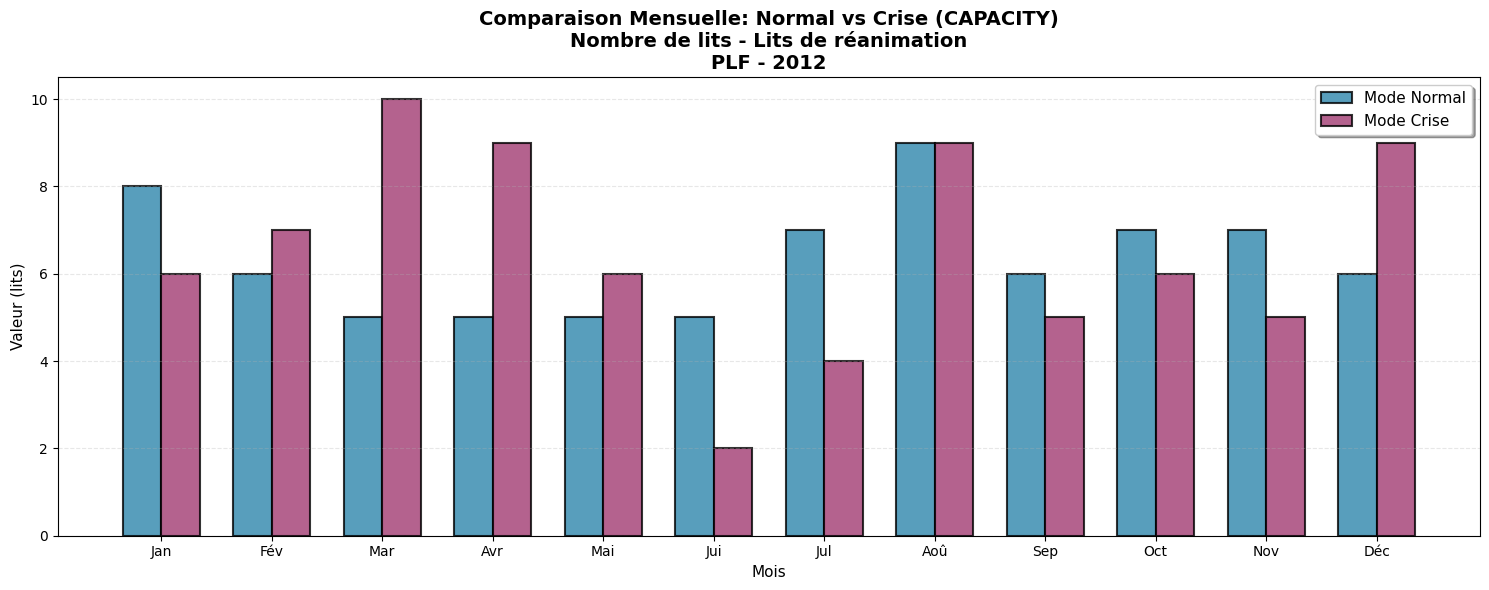


MOIS AVEC PLUS FORTE VARIATION (Crise vs Normal)
Nombre de lits - Lits de réanimation - PLF - 2012
Mois  Normal  Crise  Écart  Variation %
 Mar     5.0   10.0    5.0        100.0
 Avr     5.0    9.0    4.0         80.0
 Déc     6.0    9.0    3.0         50.0
 Mai     5.0    6.0    1.0         20.0
 Fév     6.0    7.0    1.0         16.7
 Aoû     9.0    9.0    0.0          0.0
 Oct     7.0    6.0   -1.0        -14.3
 Sep     6.0    5.0   -1.0        -16.7
 Jan     8.0    6.0   -2.0        -25.0
 Nov     7.0    5.0   -2.0        -28.6
 Jul     7.0    4.0   -3.0        -42.9
 Jui     5.0    2.0   -3.0        -60.0


In [ ]:
# ============================
# Graphique en BARRES GROUPÉES: Normal vs Crise - CAPACITY
# ============================

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

MONTHLY_CSV_PATH = "../data/capacity/capacity-donnees_mensuelles_reconstituees.csv"
df = pd.read_csv(MONTHLY_CSV_PATH)

# Paramètres
SITE = "PLF"
YEAR = 2012
INDICATEUR = "Nombre de lits"
SOUS_INDICATEUR = "Lits de réanimation"

# Filtrage
if SOUS_INDICATEUR and SOUS_INDICATEUR.strip():
    mask = (
        (df["site_code"] == SITE) &
        (df["year"] == YEAR) &
        (df["indicateur"].str.strip() == INDICATEUR) &
        (df["sous_indicateur"].str.strip() == SOUS_INDICATEUR.strip())
    )
else:
    mask = (
        (df["site_code"] == SITE) &
        (df["year"] == YEAR) &
        (df["indicateur"].str.strip() == INDICATEUR)
    )

data = df.loc[mask].copy()

if data.empty:
    print("❌ Aucune donnée trouvée.")
else:
    data = data.sort_values("month")
    
    unite = data["unite"].iloc[0] if "unite" in data.columns else ""
    sous_ind_display = f" - {SOUS_INDICATEUR}" if SOUS_INDICATEUR else ""
    
    months = np.arange(1, 13)
    x = np.arange(len(months))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(15, 6))
    
    rects1 = ax.bar(x - width/2, data["value"].values, width, 
                   label='Mode Normal', color='#2E86AB', alpha=0.8, edgecolor='black', linewidth=1.5)
    rects2 = ax.bar(x + width/2, data["value_crise"].values, width, 
                   label='Mode Crise', color='#A23B72', alpha=0.8, edgecolor='black', linewidth=1.5)
    
    ax.set_xlabel('Mois', fontsize=11)
    ax.set_ylabel(f'Valeur ({unite})' if unite else 'Valeur', fontsize=11)
    ax.set_title(f'Comparaison Mensuelle: Normal vs Crise (CAPACITY)\n{INDICATEUR}{sous_ind_display}\n{SITE} - {YEAR}', 
                fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Jui', 
                       'Jul', 'Aoû', 'Sep', 'Oct', 'Nov', 'Déc'])
    ax.legend(fontsize=11, frameon=True, shadow=True)
    ax.grid(True, axis='y', alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.show()
    
    # Classement des variations
    print("\n" + "=" * 70)
    print(f"MOIS AVEC PLUS FORTE VARIATION (Crise vs Normal)")
    print(f"{INDICATEUR}{sous_ind_display} - {SITE} - {YEAR}")
    print("=" * 70)
    
    variations = pd.DataFrame({
        "Mois": ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Jui', 'Jul', 'Aoû', 'Sep', 'Oct', 'Nov', 'Déc'],
        "Normal": data["value"].values,
        "Crise": data["value_crise"].values,
        "Écart": (data["value_crise"].values - data["value"].values),
        "Variation %": ((data["value_crise"].values / data["value"].values - 1) * 100).round(1)
    })
    variations = variations.sort_values("Variation %", ascending=False)
    print(variations.to_string(index=False))


# 📊 Analyse de Capacité: Mode Normal vs Mode Crise

## 🏥 Contexte: Pitié-Salpêtrière - Charles Foix

Ce notebook analyse les **ressources hospitalières** (lits, équipements, salles) avec 2 scénarios:

### Mode Normal (📊)
- **Logique**: Les lits et équipements fonctionnent selon une demande standard
- **Saisonnalité**: Légère concentration sur périodes critiques (hiver+été)
- **Distribution**: Plus uniforme que l'activité hospitalière

### Mode Crise (🚨)
- **Logique**: Ressources mobilisées pour crises sanitaires (COVID-19, canicules)
- **Impact**: 
  - Lits de réanimation augmentent (mars-avril, août)
  - Chambres protégées/aérées saturées
  - Blocs opératoires partiellement réaffectés
- **Distribution**: Concentrée surressources critiques

## 📈 Ce qu'il faut observer:

| Indicateur | Variation | Raison |
|-----------|-----------|--------|
| **Lits de réanimation** | ⬆️ TRÈS ÉLEVÉE | Pics COVID + canicule |
| **Lits de soins intensifs** | ⬆️ HAUTE | Ressources critiques |
| **Blocs opératoires** | ➡️ STABLE | Priorités changent mais capacité fixe |
| **Imagerie (Scanners, IRM)** | ➡️ STABLE | Équipements constants |

## 💾 Données exportées:
- **Fichier**: `capacity-donnees_mensuelles_reconstituees.csv`
- **Granularité**: Mensuelle (12 mois × 2 sites × années)
- **Colonnes**: year, month, site_code, indicateur, sous_indicateur, unite, value, value_crise


C:\Users\User\AppData\Local\Temp\ipykernel_14768\3071123713.py:58: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_14768\3071123713.py:58: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


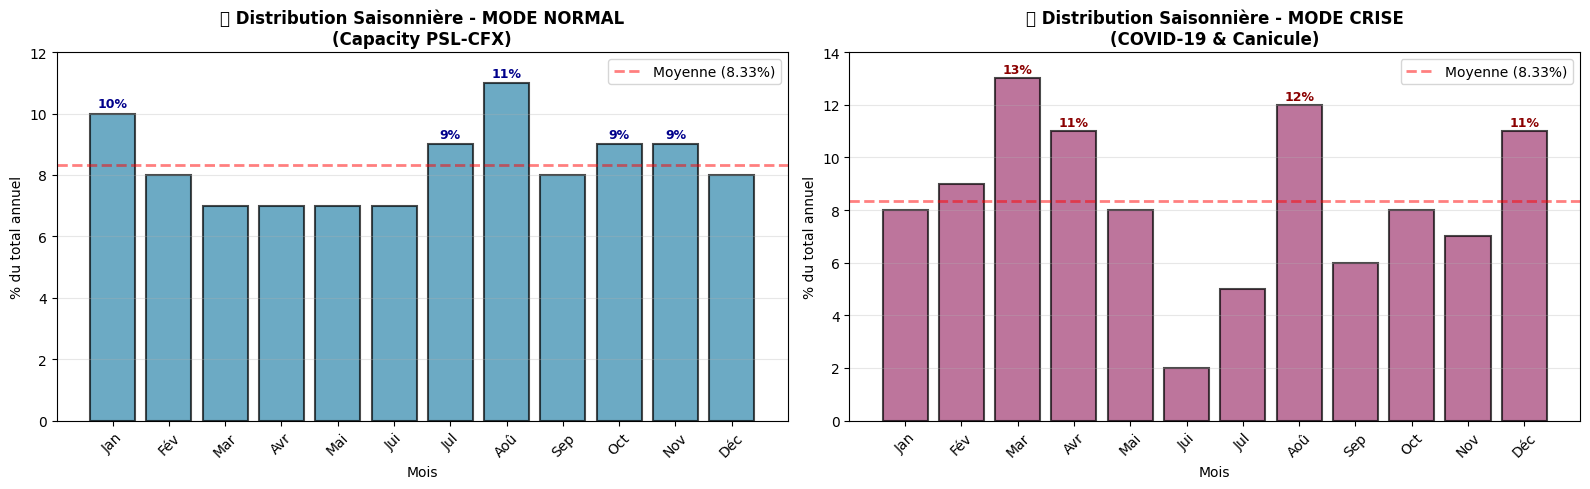


ANALYSE DES ÉCARTS DE SAISONNALITÉ - CAPACITY

📊 Tableau comparatif:
Mois  Normal %  Crise %  Écart (pts)
 Jan        10        8           -2
 Fév         8        9            1
 Mar         7       13            6
 Avr         7       11            4
 Mai         7        8            1
 Jui         7        2           -5
 Jul         9        5           -4
 Aoû        11       12            1
 Sep         8        6           -2
 Oct         9        8           -1
 Nov         9        7           -2
 Déc         8       11            3

🔍 Mois avec les plus grandes AUGMENTATIONS en crise:
   • Mar   : +  6.0 pts  (Normal:  7% → Crise: 13%)
   • Avr   : +  4.0 pts  (Normal:  7% → Crise: 11%)
   • Déc   : +  3.0 pts  (Normal:  8% → Crise: 11%)

📉 Mois avec les plus fortes DIMINUTIONS en crise:
   • Jui   :  -5.0 pts  (Normal:  7% → Crise:  2%)
   • Jul   :  -4.0 pts  (Normal:  9% → Crise:  5%)
   • Jan   :  -2.0 pts  (Normal: 10% → Crise:  8%)

📌 INTERPRÉTATION

• NORMAL: Distri

In [ ]:
# ============================
# Graphique: Distribution % Saisonnière - CAPACITY
# ============================

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Les valeurs doivent être définies dans la cellule 1
months_labels = ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Jui', 'Jul', 'Aoû', 'Sep', 'Oct', 'Nov', 'Déc']
months = range(1, 13)

# MODE NORMAL
pct_normal = [MONTH_PCT_NORMAL[m] for m in months]

# MODE CRISE
pct_crise = [MONTH_PCT_CRISE[m] for m in months]

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Graphique 1: MODE NORMAL
axes[0].bar(months, pct_normal, color='#2E86AB', alpha=0.7, edgecolor='black', linewidth=1.5)
axes[0].axhline(y=100/12, color='red', linestyle='--', alpha=0.5, linewidth=2, label='Moyenne (8.33%)')
axes[0].set_title('📊 Distribution Saisonnière - MODE NORMAL\n(Capacity PSL-CFX)', 
                 fontsize=12, fontweight='bold')
axes[0].set_xlabel('Mois', fontsize=10)
axes[0].set_ylabel('% du total annuel', fontsize=10)
axes[0].set_xticks(months)
axes[0].set_xticklabels(months_labels, rotation=45)
axes[0].grid(True, axis='y', alpha=0.3)
axes[0].legend(fontsize=10)
axes[0].set_ylim(0, max(pct_normal) + 1)

# Annotations pics
for m, pct in zip(months, pct_normal):
    if pct >= 9:
        axes[0].text(m, pct + 0.2, f'{pct}%', ha='center', fontsize=9, fontweight='bold', color='darkblue')

# Graphique 2: MODE CRISE
axes[1].bar(months, pct_crise, color='#A23B72', alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1].axhline(y=100/12, color='red', linestyle='--', alpha=0.5, linewidth=2, label='Moyenne (8.33%)')
axes[1].set_title('🚨 Distribution Saisonnière - MODE CRISE\n(COVID-19 & Canicule)', 
                 fontsize=12, fontweight='bold')
axes[1].set_xlabel('Mois', fontsize=10)
axes[1].set_ylabel('% du total annuel', fontsize=10)
axes[1].set_xticks(months)
axes[1].set_xticklabels(months_labels, rotation=45)
axes[1].grid(True, axis='y', alpha=0.3)
axes[1].legend(fontsize=10)
axes[1].set_ylim(0, max(pct_crise) + 1)

# Annotations pics
for m, pct in zip(months, pct_crise):
    if pct >= 11:
        axes[1].text(m, pct + 0.2, f'{pct}%', ha='center', fontsize=9, fontweight='bold', color='darkred')

plt.tight_layout()
plt.show()

# Tableau comparatif
print("\n" + "=" * 70)
print("ANALYSE DES ÉCARTS DE SAISONNALITÉ - CAPACITY")
print("=" * 70)

ecarts = pd.DataFrame({
    "Mois": months_labels,
    "Normal %": pct_normal,
    "Crise %": pct_crise,
    "Écart (pts)": [pct_crise[i] - pct_normal[i] for i in range(12)]
})

print("\n📊 Tableau comparatif:")
print(ecarts.to_string(index=False))

print("\n🔍 Mois avec les plus grandes AUGMENTATIONS en crise:")
top_ecarts = ecarts.nlargest(3, 'Écart (pts)')
for _, row in top_ecarts.iterrows():
    print(f"   • {row['Mois']:6s}: +{row['Écart (pts)']:5.1f} pts  (Normal: {row['Normal %']:2d}% → Crise: {row['Crise %']:2d}%)")

print("\n📉 Mois avec les plus fortes DIMINUTIONS en crise:")
low_ecarts = ecarts.nsmallest(3, 'Écart (pts)')
for _, row in low_ecarts.iterrows():
    print(f"   • {row['Mois']:6s}: {row['Écart (pts)']:+5.1f} pts  (Normal: {row['Normal %']:2d}% → Crise: {row['Crise %']:2d}%)")

print("\n" + "=" * 70)
print("📌 INTERPRÉTATION")
print("=" * 70)
print("""
• NORMAL: Distribution relativement uniforme (lits constants)
          Légère concentration sur périodes de pic (hiver + été)
          
• CRISE:  Concentration sur ressources critiques (mars-avril, août)
          Compression des ressources moins essentielles (juin)
          Augmentation légère mais marquée des lits de réa/soins intensifs
""")
